In [9]:
from matplotlib.pylab import mpl
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D ,Dense,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard

In [10]:
(train_x,train_y),(test_x,test_y)=mnist.load_data()
print(train_x.shape,train_y.shape,train_x.dtype,type(train_x))
def process(x,y=None):
    x = x.reshape((x.shape[0],x.shape[1],x.shape[2],1)) # np.squeeze() 移除维度 没有unsqueeze
    x = x.astype(np.float32) / 255
    y = to_categorical(y)
    return x ,y
train_x,train_y =process(train_x,train_y)
test_x,test_y =process(test_x,test_y)
X_train , X_test = train_x.reshape((train_x.shape[0],-1)),test_x.reshape((test_x.shape[0],-1))

(60000, 28, 28) (60000,) uint8 <class 'numpy.ndarray'>


In [12]:
X_train, X_test = train_x.reshape((train_x.shape[0], -1)), test_x.reshape((test_x.shape[0], -1))
class MyNet():
    def __init__(self, input_shape, neuron_nums=None, h=1e-5, epochs=30, lr=0.2, batch_size=64,weight_scale=1.0):
        self.params = {}
        if neuron_nums is None:
            neuron_nums = [50, 100, 10]
        self.input_shape = input_shape
        self.neuron_nums = neuron_nums
        self.eps = 1e-7  # 数值稳定用,log中
        self.h = h  # 数值差分的最小delta
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.weight_scale = weight_scale
        self.history = {'acu':{},'loss':{}}
        assert len(input_shape) == 2

    def init_net(self):
        n1, n2, n3 = self.neuron_nums
        w1 = np.random.randn(self.input_shape[1], n1) * self.weight_scale
        b1 = np.ones(n1)
        w2 = np.random.randn(n1, n2) * self.weight_scale
        b2 = np.ones(n2)
        w3 = np.random.randn(n2, n3) * self.weight_scale
        b3 = np.ones(n3)
        keys = ["w1", "w2", "w3", "b1", "b2", "b3"]
        params = [w1, w2, w3, b1, b2, b3]
        for key, param in zip(keys, params):
            self.params[key] = param

    def fit(self, X_train, y_train):
        self.X = X_train
        self.y = y_train
        self.init_net()
        print("initialize net sucessful..")
        print("gradient_descent starting..")
        self.gradient_descent()
        print("gradient_descent finished..")

    def gradient_descent(self):
        index_list = np.arange(self.X.shape[0])
        np.random.shuffle(index_list)
        if self.X.shape[0] % self.batch_size == 0:
            self.iterations = self.X.shape[0] // self.batch_size
        else:
            self.iterations = self.X.shape[0] // self.batch_size + 1
        for epoch in range(self.epochs):
            self.history['acu'][epoch + 1] = []
            self.history['loss'][epoch + 1] = []
            for iter in range(self.iterations):
                if iter != self.iterations - 1:
                    X_batch = self.X[iter * self.batch_size:iter * self.batch_size + self.batch_size]
                    y_batch = self.y[iter * self.batch_size:iter * self.batch_size + self.batch_size]
                else:
                    # 处理边界 最后1步为了不越界使用
                    X_batch = self.X[iter * self.batch_size:]
                    y_batch = self.y[iter * self.batch_size:]
                #print(epoch + 1, iter + 1, X_batch.shape, y_batch.shape)
                train_batch_acu = self.train_batch_score(X_batch, y_batch)
                train_batch_loss = self.train_batch_loss(X_batch, y_batch)
                grads = self.backward(X_batch,y_batch) # 数值微分
                # grads = self.batch_layer_params_gradient(X_batch, y_batch)  # 每批计算所有参数的梯度
                for key in self.params.keys():  # 执行梯度下降
                    #print("[%s] = [%s] - lr * grads[%s] starting.." % (key, key, key))
                    #if grads[key].ndim == 2:
                        #print("[%s]_grad_0_0=[%.5f]" % (key, grads[key][0, 0]))
                    #else:
                        #print("[%s]_grad_0_0=[%.5f]" % (key, grads[key][0]))
                    self.params[key] -= self.lr * grads[key]
                    #print("[%s] = [%s] - lr * grads[%s] finished.." % (key, key, key))
                self.history['acu'][epoch + 1].append(train_batch_acu)
                self.history['loss'][epoch + 1].append(train_batch_loss)
                print("epoch：%s iter：%s train_acu=%.5f train_loss=%.5f" % (
                epoch + 1, iter + 1, train_batch_acu, train_batch_loss))
    def forward(self, X):
        self.layer1 = X.dot(self.params["w1"]) + self.params["b1"] # (N,784)*(784,50)+(50,)
        self.z1 = self.relu(self.layer1) # (N,50)
        self.layer2 = self.z1.dot(self.params["w2"]) + self.params["b2"]# (N,50)*(50,100)+(100,)
        self.z2 = self.relu(self.layer2) #(N,100)
        self.out = self.z2.dot(self.params["w3"]) + self.params["b3"] # (N,100)*(100,10)+(10,)
        # 输出10个节点，说明每个样本输出10个值，也就是要求标签为独热编码
        self.out_proba = self.softmax(self.out) # (N,10)
        return self.out_proba
    def backward(self,X,y):
        '''
        :param X: 当前批次
        :param y: 当前批次
        :return:  当前批次损失对w1,w2,w3,b1,b2,b3的梯度
        （1）初始化类成为对象后，调用fit函数
             fit函数先执行init_net函数初始化网络生成6个参数，其次执行gradient_descent函数执行梯度下降
        （2）gradient_descent函数设定epoch和iter双循环，执行前向传播和反向传播，计算梯度并更新参数
        （3）执行backward反向传播之前先执行前向传播forward
             gradient_descent函数中调用train_batch_score
             train_batch_score函数中调用forward
             forward中就依次计算了不同层的输出作为类属性self.layer1,self.layer2,self.out,self.z1,self.z2,self.out_proba
        （4）backward函数从输出层开始依次执行节点函数的反向梯度计算直到输入层
             1）loss<-out_proba、out_proba(softmax)<-out
                一般直接合并计算即可，即直接计算loss对out的梯度，记out_proba=p,out=z,y_batch=y
                首先：loss = -y1*log(p1)-y2*log(p2)-y3*log(p3)
                其次：pi = exp(zi)/[exp(z1)+exp(z2)+exp(z3)] i = 1,2,3
                loss对zi的偏导=loss对pi的偏导 * pi对zi的偏导
                根据数学计算可得结论为 ∂loss/∂zi = pi - yi，即dloss_dout，作为下层的上游梯度
             2）out<-w3@z2+b3
                全连接层涉及矩阵的求导运算 ：
                    当 Y = W @ X + b时 dY/dX=W'
                    当 Y = X @ W + b 时 dY/dX=W' dY/dW=X'@上游梯度 dY/db=上游梯度在轴0的求和
                故 dout_dz2 = w3'
                   dloss_dw3 = z2.T @ dloss_dout
                   dloss_db3 = np.sum(dloss_dout,axis=0)
                此时dloss_dz2 = dloss_dout @ dout_dz2 作为下层的上游梯度
             3）z2<-relu(layer2)
                前向传送时layer2小于等于0的数全置为0，故反向传播也是只需要对上游梯度置零即可
                此时 dloss_dlayer2 = dloss_dz2[self.layer2 <= 0] = 0 作为下层的上游梯度
            4）layer2<-w2@z1+b2
               和步骤2）类似，区别在于当前的上游梯度是dloss_dlayer2，数值导数为z1.T
               dlayer2_dz1 = w2'
               dloss_dw2 = z1.T @ dloss_dlayer2
               dloss_db2 = np.sum(dloss_dlayer2,axis=0)
               此时dloss_dz1 = dloss_dlayer2 @ dlayer2_dz1 作为下层的上游梯度
            5） z1<-relu(layer1)
               和步骤3）类似
               此时 dloss_dlayer1 = dloss_dz1[self.layer1 <= 0] = 0 作为下层的上游梯度
            6）layer1<-w1@X+b1
               和步骤2）类似，区别在于当前的上游梯度是dloss_dlayer1，数值导数为X.T
               dlayer1_dz1 = w1'
               dloss_dw1 = X.T @ dloss_dlayer1
               dloss_db1 = np.sum(dloss_dlayer1,axis=0)
               此时dloss_dX = dloss_dlayer1 @ dlayer1_dX 作为最终梯度
        （5）backward运行结束后，此时参数达到最佳，结束程序，dloss_dX没有什么用
        '''
        grads = {}
        # softmax层的反向传播 ：节点左侧是self.out(Z)，节点右侧是self.out_proba(P) <- loss_W，跳过了对P求导，直接对Z求导
        # loss = -y1*log(p1)-y2*log(p2)-y3*log(p3)
        # p1 = exp(z1)/[exp(z1)+exp(z2)+exp(z3)],p2 = exp(z2)/[exp(z1)+exp(z2)+exp(z3)],p3 = exp(z3)/[exp(z1)+exp(z2)+exp(z3)]
        # loss对z1的导数也就是loss_W对self.out_proba的10个节点的导数
        # 每个节点都可以写为loss对p1导数和p1对z1的导数的乘积，为p1(y1+y2+y3)-y1,p2(y1+y2+y3)-y2,p3(y1+y2+y3)-y3
        # 因为y1+y2+y3=E（矩阵形式），所以所有节点可以统一成 p-y，这里y对应self.y
        self.dloss_dout = (self.out_proba - y) / self.y.shape[0] # (N,10)

        # 第二层w3、b3的反向传播：节点两侧是self.z2和self.out
        # self.out = self.z2 * w3 + b3        (N,10)=(N,100)*(100,10)+(10,)
        # 矩阵求导公式 ：① Y = W * X --> dY/dX = W' ② Y = X' * W --> dY/dX = W
        # 假设 Y = X * W ，同时转置有 Y'= W'*X'，那么根据公式①dY'/dX' = W，同时转置dY/dX = W'
        self.dout_dz2 = self.params['w3'].T  # (10,100) 当前层对X求偏导为参数W的转置
        self.dloss_dw3 = np.dot(self.z2.T,self.dloss_dout)  # 对当前层参数W求偏导为X的转置，区别还需要乘上游导数值
        self.dloss_db3 = np.sum(self.dloss_dout,axis=0) # 偏置量求和即可
        dloss_dz2 = self.dloss_dout.dot(self.dout_dz2)

        # 第二层激活层relu的反向传播：节点两侧是self.layer2和self.z2
        dloss_dz2[self.layer2 <= 0] = 0
        dloss_dlayer2 = dloss_dz2

        # 类似的
        self.dlayer2_dz1 = self.params['w2'].T
        self.dloss_dw2 = np.dot(self.z1.T,dloss_dlayer2)
        self.dloss_db2 = np.sum(dloss_dlayer2, axis=0)
        dloss_dz1 = dloss_dlayer2.dot(self.dlayer2_dz1)

        dloss_dz1[self.layer1<=0] = 0
        dloss_dlayer1 = dloss_dz1

        self.dlayer1_dX = self.params['w1'].T
        self.dloss_dw1 = np.dot(X.T,dloss_dlayer1)
        self.dloss_db1 = np.sum(dloss_dlayer1, axis=0)

        self.dloss_dX = dloss_dlayer1.dot(self.dlayer1_dX)
        # print(self.dloss_dw3.shape,self.dloss_dw2.shape,self.dloss_dw1.shape)
        # print(self.dloss_db3.shape,self.dloss_db2.shape,self.dloss_db1.shape)
        # (100, 10) (50, 100) (784, 50)
        # (10,)(100, )(50, )
        grads['w3'] = self.dloss_dw3
        grads['w2'] = self.dloss_dw2
        grads['w1'] = self.dloss_dw1
        grads['b3'] = self.dloss_db3
        grads['b2'] = self.dloss_db2
        grads['b1'] = self.dloss_db1
        return grads
    def train_score(self):
        y_pred = self.forward(self.X)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(self.y, axis=1)
        return np.sum(y_true == y_pred) / len(y_true)
    def train_batch_score(self, X_batch, y_batch):
        y_pred = self.forward(X_batch)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_batch, axis=1)
        return np.sum(y_true == y_pred) / len(y_true)
    def train_loss(self):
        # print(self.out_proba.shape) # (60000, 10)
        # 直接计算所有样本的前向损失：对应元素相乘求和取平均
        y_pred = self.forward(self.X)
        return self.cross_entropy_error(y_pred=y_pred, y_true=self.y)
    def train_batch_loss(self, X_batch, y_batch):
        y_pred = self.forward(X_batch)
        return self.cross_entropy_error(y_pred=y_pred, y_true=y_batch)
    def layer_param_gradient(self, loss, layer_param, key):
        grad = np.zeros_like(layer_param)
        # print("[%s]_0_0=[%.5f]"%(key,layer_param[0,0]))
        index_genegrator = np.nditer(layer_param, flags=['multi_index'], op_flags=['readwrite'])
        while not index_genegrator.finished:
            index = index_genegrator.multi_index  # 每个参数的所有元素索引
            # 如对W1的W11参数更新，类似的W1的其他参数也是如此
            # 计算W11的差分时其他参数不动，[ f(W11+h,W12,W13...Wnn)-f(W11-h,W12,W12,..,Wnn) ] / 2h
            temp = layer_param[index]
            layer_param[index] = float(temp) + self.h  # 前向更新
            loss_forward = loss(layer_param)
            layer_param[index] = float(temp) - self.h  # 反向更新
            loss_backward = loss(layer_param)
            grad[index] = (loss_forward - loss_backward) / 2 * self.h
            layer_param[index] = temp  # 还原值 因为参数不在这里更新，所以要还原
            # print(f"{key}[{index}]=[{temp} front={loss_forward}back={loss_backward}] gradient finished...")
            index_genegrator.iternext()
        return grad
    def batch_layer_params_gradient(self, X_batch, y_batch):
        # 数值微分
        grads ={}
        print("batch_layer_params_gradient starting...")
        # 定义1个关于W的批损失函数 每批都重新定义是因为每批的权重发生了改变应当重新计算损失
        #loss_W = self.Xb.T.dot(self.sigmoid(self.Xb.dot(self.w)) - self.y) / len(self.y)
        loss_W = lambda W: self.train_batch_loss(X_batch, y_batch)
        # 数值梯度
        for key in self.params.keys():
            print(f"{key} layer_param_gradient starting...")
            grads[key] = self.layer_param_gradient(loss_W, self.params[key], key)
            print(f"{key} layer_param_gradient finished...")
        print("batch_layer_params_gradient finished...")
        return grads
    def predict(self, X_test):
        # 预测时使用的是此时最好的参数
        layer1 = X_test.dot(self.params["w1"]) + self.params["b1"]
        z1 = self.relu(layer1)
        layer2 = z1.dot(self.params["w2"]) + self.params["b2"]
        z2 = self.relu(layer2)
        out = z2.dot(self.params["w3"]) + self.params["b3"]
        y_pred = self.softmax(out)
        return y_pred
    def cross_entropy_error(self, y_pred, y_true):
        return -np.sum(y_true * np.log(y_pred + self.eps)) / y_pred.shape[0]
    def softmax(self, x):
        if x.ndim == 2:
            # 传入的是矩阵时 如(4,6)必须修改，否则矩阵的所有元素和为1了
            # 注：对于sigmoid和relu函数没有影响
            # 现在要求x的每列和为1，故找到每列的最大值
            c = np.max(x, axis=1)  # (4,)
            exp_x = np.exp(x.T - c)  # (4,6)-(4,)是不能广播的，需要转置为(6,4)-(4,)-->(6,4),需要后缘维度相同
            return (exp_x / np.sum(exp_x, axis=0)).T  # np.sum(exp_x,axis=0) =(4,) 每列除对应值
        c = np.max(x)
        exp_x = np.exp(x - c)
        return exp_x / np.sum(exp_x)
    def relu(self, x):
        # return np.array(list(map(lambda a: 0 if a < 0 else a, x))) 只适合向量
        return np.maximum(0, x)
mynet = MyNet(input_shape=X_train.shape, neuron_nums=[512,128,10])
mynet.fit(X_train, train_y)

initialize net sucessful..
gradient_descent starting..
epoch：1 iter：1 train_acu=0.10938 train_loss=14.35518
epoch：1 iter：2 train_acu=0.07812 train_loss=14.85887
epoch：1 iter：3 train_acu=0.07812 train_loss=14.85887
epoch：1 iter：4 train_acu=0.14062 train_loss=13.85149
epoch：1 iter：5 train_acu=0.12500 train_loss=14.10333
epoch：1 iter：6 train_acu=0.14062 train_loss=13.85149
epoch：1 iter：7 train_acu=0.18750 train_loss=13.09596
epoch：1 iter：8 train_acu=0.10938 train_loss=14.35518
epoch：1 iter：9 train_acu=0.09375 train_loss=14.60702
epoch：1 iter：10 train_acu=0.17188 train_loss=13.34780
epoch：1 iter：11 train_acu=0.09375 train_loss=14.60702
epoch：1 iter：12 train_acu=0.06250 train_loss=15.11071
epoch：1 iter：13 train_acu=0.15625 train_loss=13.59964
epoch：1 iter：14 train_acu=0.12500 train_loss=13.98267
epoch：1 iter：15 train_acu=0.07812 train_loss=14.85887
epoch：1 iter：16 train_acu=0.15625 train_loss=13.59964
epoch：1 iter：17 train_acu=0.12500 train_loss=13.95267
epoch：1 iter：18 train_acu=0.12500 tr

c:\users\chenb\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


0.8991166666666667 1.495011135377486
0.8873


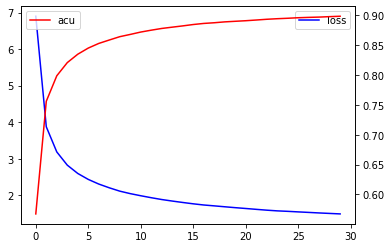

In [13]:
epoch_loss = [np.mean(epoch_iter_loss) for epoch_iter_loss in mynet.history['loss'].values() ]
epoch_acu = [np.mean(epoch_iter_acu) for epoch_iter_acu in mynet.history['acu'].values() ]
fig , ax = plt.subplots()
axx = ax.twinx()
ax.plot(epoch_loss,label='loss',color='b')
axx.plot(epoch_acu,label='acu',color='r')
ax.legend()
axx.legend()
fig.show()
print(mynet.train_score(), mynet.train_loss())
print(np.sum((np.argmax(mynet.predict(X_test),axis=1)==np.argmax(test_y,axis=1)))/len(test_y))